# ロバストQ学習

参考
* [Online Robust Reinforcement Learning with Model Uncertainty](https://arxiv.org/abs/2109.14523)

多くのロバストRLではUncertainty setが既知であったり、モデルベースの手法を使ったりします。
しかし、現実ではそのような場合は稀です。
ロバストMDPをオンラインで解くアルゴリズムについて見てみましょう。

## 表記

* 遷移カーネル：$\mathrm{P}=\left\{p_s^a \in \Delta_{|\mathcal{S}|}, a \in \mathcal{A}, s \in \mathcal{S}\right\}$
    * 状態$s, a$での確率分布：$p_s^a=\left\{p_{s, s^{\prime}}^a\right\}_{s^{\prime} \in \mathcal{S}}$
* 割引率：$\gamma$
* 時刻$t$での遷移カーネル：$\mathrm{P}_t$
* 各時刻の遷移確率：$\kappa=\left(\mathrm{P}_0, \mathrm{P}_1, \ldots\right)$。それぞれの時刻での遷移確率はUncertainty setからAdversarialに選択される （$\mathrm{P}_t \in \mathbf{P}, \forall t \geq 0$）
* 状態空間$\mathcal{S}$で条件付けられた$p_s^a$の分布：$\mathcal{P}_s^a$
* $\sigma_{\mathcal{P}}(v) \triangleq \max _{p \in \mathcal{P}}\left(p^{\top} v\right)$
* 最適状態価値関数：$V^*(s)=\min _{a \in \mathcal{A}}\left(c(s, a)+\gamma \sigma_{\mathcal{P}_s a}\left(V^*\right)\right)$
* 最適状態行動価値関数：$Q^*(s, a)=c(s, a)+\gamma \sigma_{\mathcal{P} a}\left(V^*\right)$
* ロバストベルマン作用素：$\mathbf{T} Q(s, a)=c(s, a)+\gamma \sigma_{\mathcal{P} a}\left(\min _{a \in \mathcal{A}} Q(s, a)\right)$

以下、$\mathrm{P}=\left\{p_s^a, s \in \mathcal{S}, a \in \mathcal{A}\right\}$をUncertainty setの中心遷移カーネルとします。
つまり、Uncertainty setはこの中心遷移カーネルを摂動させた形で形成されるとします。また、$\mathrm{P}$は未知であるとします。

摂動させて作る次のUncertainty setを$R$-contamination モデルと呼びます：

$$
\mathcal{P}_s^a=\left\{(1-R) p_s^a+R q \mid q \in \Delta_{|\mathcal{S}|}\right\}, s \in \mathcal{S}, a \in \mathcal{A}, \text { for some } 0 \leq R \leq 1
$$

$\mathbf{P}=\bigotimes_{s \in \mathcal{S}, a \in \mathcal{A}} \mathcal{P}_s^a$とする。

## Robust Q学習

$O_t=\left(s_t, a_t, s_{t+1}\right)$とします。各時刻で遷移確率は変化しますが、
$$
\hat{p}_t \triangleq \mathbb{1}_{s_{t+1}}
$$
は$p_{s_t}^{a_t}$の普遍推定になっています。（$\mathbb{1}$は$s_{t+1}$にだけ$1$を取る退化した分布です。）
これに基づいて、Uncertainty set$\mathcal{P} a_{s_t}$の推定を

$$
\hat{\mathcal{P}}_t \triangleq\left\{(1-R) \hat{p}_t+R q \mid q \in \Delta_{|\mathcal{S}|}\right\}
$$

とします。

---

以上を踏まえて、Robust Q学習では次のように更新します：

$$
Q_{t+1}\left(s_t, a_t\right) \leftarrow\left(1-\alpha_t\right) Q_t\left(s_t, a_t\right)+\alpha_t\left(c_t+\gamma R \max _{s \in \mathcal{S}} V_t(s)+\gamma(1-R) V_t\left(s_{t+1}\right)\right)
$$

---

これがQ学習の所望の性質を満たすことを確認しましょう。

---

$\sum_{t=0}^{\infty} \alpha_t=\infty$ と $\sum_{t=0}^{\infty} \alpha_t^2<\infty$が成立してある時、$Q_t \rightarrow Q^*$が$t\rightarrow \infty$なら確率$1$で成立します。

証明してみましょう。ここで、ロバスト最適価値観数の定義より、

$$
Q^*(s, a)=c(s, a)+\gamma \sigma_{\mathcal{P}_s a}\left(\left(\min _{a \in \mathcal{A}} Q^*\left(s_1, a\right), \min _{a \in \mathcal{A}} Q^*\left(s_2, a\right), \ldots, \min _{a \in \mathcal{A}} Q^*\left(s_{|\mathcal{S}|}, a\right)\right)^{\top}\right)
$$

であることを思い出してください（これはベクトル形式の$Q$をわざわざ要素ごとに書き換えた形です）。
このとき、

$$
\begin{aligned}
\mathbf{T} Q(s, a) & =c(s, a)+\gamma \sigma_{\mathcal{P}_s^a}(V) \\
& =c(s, a)+\gamma(1-R)\left(p_s^a\right)^{\top} V+R \max _{s^{\prime}} V\left(s^{\prime}\right) \\
& =c(s, a)+\gamma(1-R) \sum_{s^{\prime}}\left(p_{s, s^{\prime}}^a\right) V\left(s^{\prime}\right)+R \max _{s^{\prime}} V\left(s^{\prime}\right) \\
& =c(s, a)+\gamma \sum_{s^{\prime}} p_{s, s^{\prime}}^a\left((1-R)\left(\mathbb{1}_{s^{\prime}}\right)^{\top} V+R \max _q q^{\top} V\right)
\end{aligned}
$$

であるから、Robust Q学習の更新は普遍推定による更新になっています。
また、このベルマン作用素はちゃんとContractionにもなっています（R-contaminationの形なのでRobust RLと少し違います）。

$$
\begin{aligned}
& \left|\mathbf{T} Q(s, a)-\mathbf{T} Q^{\prime}(s, a)\right| \\
& =\left|c(s, a)+\gamma \sigma_{\mathcal{P}_s a}(V)-c(s, a)-\gamma \sigma_{\mathcal{P}_s}\left(V^{\prime}\right)\right| \\
& =\gamma\left|\sigma_{\mathcal{P}_s}(V)-\sigma_{\mathcal{P}_s a}\left(V^{\prime}\right)\right| \\
& =\gamma\left|\max _q\left\{(1-R)\left(p_s^a\right)^{\top} V+R q^{\top} V\right\}-\max _{q^{\prime}}\left\{(1-R)\left(p_s^a\right)^{\top} V^{\prime}+R q^{\prime \top} V^{\prime}\right\}\right| \\
& =\gamma\left|\sum_{s^{\prime} \in \mathcal{S}} p_{s, s^{\prime}}^a\left((1-R) V\left(s^{\prime}\right)\right)+R \max _{s^{\prime}} V\left(s^{\prime}\right)-\sum_{s^{\prime} \in \mathcal{S}} p_{s, s^{\prime}}^a\left((1-R) V^{\prime}\left(s^{\prime}\right)\right)-R \max _{s^{\prime}} V^{\prime}\left(s^{\prime}\right)\right| \\
& =\gamma\left|\sum_{s^{\prime} \in \mathcal{S}} p_{s, s^{\prime}}^a(1-R)\left(V\left(s^{\prime}\right)-V^{\prime}\left(s^{\prime}\right)\right)+R\left(\max _{s^{\prime}} V\left(s^{\prime}\right)-\max _{s^{\prime}} V^{\prime}\left(s^{\prime}\right)\right)\right| \\
& \leq \gamma\left|\sum_{s^{\prime} \in \mathcal{S}} p_{s, s^{\prime}}^a(1-R)\left(\min _a Q\left(s^{\prime}, a\right)-\min _b Q^{\prime}\left(s^{\prime}, b\right)\right)\right|+\gamma R\left(\left|\max _{s^{\prime}} V\left(s^{\prime}\right)-\max _{s^{\prime}} V^{\prime}\left(s^{\prime}\right)\right|\right) \\
& \leq \gamma \sum_{s^{\prime} \in \mathcal{S}} p_{s, s^{\prime}}^a(1-R)\left|\left(\min _a Q\left(s^{\prime}, a\right)-\min _b Q^{\prime}\left(s^{\prime}, b\right)\right)\right|+\gamma R \max _s\left|\left(V(s)-V^{\prime}(s)\right)\right| \\
& (a) \\
& \leq \gamma \sum_{s^{\prime} \in \mathcal{S}} p_{s, s^{\prime}}^a(1-R)\left\|Q-Q^{\prime}\right\|_{\infty}+\gamma R\left\|Q-Q^{\prime}\right\|_{\infty} \\
& \leq \gamma\left\|Q-Q^{\prime}\right\|_{\infty},
\end{aligned}
$$

あとは [強化学習 (機械学習プロフェッショナルシリーズ) , 66ページ付近　](https://www.amazon.co.jp/%E5%BC%B7%E5%8C%96%E5%AD%A6%E7%BF%92-%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%97%E3%83%AD%E3%83%95%E3%82%A7%E3%83%83%E3%82%B7%E3%83%A7%E3%83%8A%E3%83%AB%E3%82%B7%E3%83%AA%E3%83%BC%E3%82%BA-%E6%A3%AE%E6%9D%91-%E5%93%B2%E9%83%8E/dp/4065155916/ref=asc_df_4065155916/?tag=jpgo-22&linkCode=df0&hvadid=310429813636&hvpos=&hvnetw=g&hvrand=6867034787001615408&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=1009224&hvtargid=pla-675730625220&psc=1&th=1&psc=1)
あたりのロビンス・モンローと合わせた収束を証明すればOKです。


$\mu_{\pi_b}$を$\pi_b$の定常分布とします。
また、$\mu_{\min }=\min _{(s, a) \in \mathcal{S} \times \mathcal{A}} \mu_{\pi_b}(s, a)$とします。さらに
$t_{\mathrm{mix}}=\min \left\{t: \max _{s \in \mathcal{S}} d_{\mathrm{TV}}\left(\mu_\pi, P\left(s_t=\cdot \mid s_0=s\right)\right) \leq \frac{1}{4}\right\}$をMDPのMixing timeとします。
（動いている分布が定常分布に近づく時間のことをMixing timeといいます。[Markov chain mixing time](https://en.wikipedia.org/wiki/Markov_chain_mixing_time)参照。）

今回は詳しく記述しませんが、適切なBehavior方策$\pi_b$を選択して、MDPにergodicな仮定が入っていれば、イテレーションの回数$T$が

$$
T \geq c_0\left(\frac{1}{\mu_{\text {min }}(1-\gamma)^5 \epsilon^2}+\frac{t_{\text {mix }}}{\mu_{\min }(1-\gamma)}\right) \log \left(\frac{T|\mathcal{S}||\mathcal{A}|}{\delta}\right) \log \left(\frac{1}{\epsilon(1-\gamma)^2}\right)
$$
以上であり、また、学習率が$\alpha_t=\frac{c_1}{\log \left(\frac{T|\delta||\mathcal{A}|}{\delta}\right)} \min \left(\frac{1}{t_{\text {mix }}}, \frac{\epsilon^2(1-\gamma)^4}{\gamma^2}\right)$であれば、確率$1-6\delta$以上で

$$
\left\|Q_T-Q^*\right\|_{\infty} \leq 3 \epsilon
$$

が成り立ちます。つまり、サンプル効率が

$$
\tilde{\mathcal{O}}\left(\frac{1}{\mu_{\min }(1-\gamma)^5 \epsilon^2}+\frac{t_{\operatorname{mix}}}{\mu_{\min }(1-\gamma)}\right)
$$
であることも導出できます。これはQ学習のサンプル効率とほぼ同じです。

In [98]:
import numpy as np
import jax.numpy as jnp
from jax.random import PRNGKey
import jax
from typing import NamedTuple, Optional

key = PRNGKey(0)

S = 10  # 状態集合のサイズ
A = 3  # 行動集合のサイズ
S_set = jnp.arange(S)  # 状態集合
A_set = jnp.arange(A)  # 行動集合
gamma = 0.95  # 割引率


# 報酬行列を適当に作ります
key, _ = jax.random.split(key)
rew = jax.random.uniform(key=key, shape=(S, A))
assert rew.shape == (S, A)


# 遷移確率行列を適当に作ります
key, _ = jax.random.split(key)
P = jax.random.uniform(key=key, shape=(S*A, S))
P = P / jnp.sum(P, axis=-1, keepdims=True)  # 正規化して確率にします
P = P.reshape(S, A, S)
np.testing.assert_allclose(P.sum(axis=-1), 1, atol=1e-6)  # ちゃんと確率行列になっているか確認します


# 初期状態分布を適当に作ります
key, _ = jax.random.split(key)
mu = jax.random.uniform(key, shape=(S,))
mu = mu / jnp.sum(mu)
np.testing.assert_allclose(mu.sum(axis=-1), 1, atol=1e-6)  # ちゃんと確率行列になっているか確認します


# 状態集合, 行動集合, 割引率, 報酬行列, 遷移確率行列が準備できたのでMDPのクラスを作ります

class MDP(NamedTuple):
    S_set: jnp.array  # 状態集合
    A_set: jnp.array  # 行動集合
    gamma: float  # 割引率
    H: int  # エフェクティブホライゾン
    rew: jnp.array  # 報酬行列
    P: jnp.array  # 遷移確率行列
    mu: jnp.array  # 初期分布
    optimal_Q: Optional[jnp.ndarray] = None  # 最適Q値

    @property
    def S(self) -> int:  # 状態空間のサイズ
        return len(self.S_set)

    @property
    def A(self) -> int:  # 行動空間のサイズ
        return len(self.A_set)


H = int(1 / (1 - gamma))
mdp = MDP(S_set, A_set, gamma, H, rew, P, mu)


In [99]:
import jax
import jax.numpy as jnp
import numpy as np
from functools import partial
import chex


@jax.jit
def compute_greedy_policy(Q: jnp.ndarray):
    """Q関数の貪欲方策を返します

    Args:
        Q (jnp.ndarray): (SxA)の行列

    Returns:
        greedy_policy (jnp.ndarray): (SxA)の行列
    """
    greedy_policy = jnp.zeros_like(Q)
    S, A = Q.shape
    greedy_policy = greedy_policy.at[jnp.arange(S), Q.argmax(axis=1)].set(1)
    assert greedy_policy.shape == (S, A)
    return greedy_policy


@partial(jax.jit, static_argnames=("S", "A"))
def _compute_optimal_Q(mdp: MDP, S: int, A: int):
    """MDPについて、ベルマン最適作用素を複数回走らせて最適価値関数を動的計画法で計算します。
    Args:
        mdp (MDP)

    Returns:
        optimal_Q (jnp.ndarray): (SxA)の行列
    """

    def backup(optimal_Q):
        next_v = mdp.P @ optimal_Q.max(axis=1)
        assert next_v.shape == (S, A)
        return mdp.rew + mdp.gamma * next_v
    
    optimal_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.H + 100, body_fn, optimal_Q)

compute_optimal_Q = lambda mdp: _compute_optimal_Q(mdp, mdp.S, mdp.A)


@jax.jit
def compute_policy_Q(mdp: MDP, policy: jnp.ndarray):
    """MDPと方策について、ベルマン期待作用素を複数回走らせて価値関数を動的計画法で計算します。
    Args:
        mdp (MDP)
        policy (jnp.ndarray): (SxA)の行列

    Returns:
        optimal_Q (jnp.ndarray): (SxA)の行列
    """
    S, A = policy.shape
    chex.assert_shape(policy, (mdp.S, mdp.A))

    def backup(policy_Q):
        max_Q = (policy * policy_Q).sum(axis=1)
        next_v = mdp.P @ max_Q
        assert next_v.shape == (S, A)
        return mdp.rew + mdp.gamma * next_v
    
    policy_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.H + 100, body_fn, policy_Q)


@jax.jit
def compute_policy_matrix(policy: jnp.ndarray):
    """
    上で定義した方策行列を計算します。方策についての内積が取りたいときに便利です。
    Args:
        policy (jnp.ndarray): (SxA)の行列

    Returns:
        policy_matrix (jnp.ndarray): (SxSA)の行列
    """
    S, A = policy.shape
    PI = policy.reshape(1, S, A)
    PI = jnp.tile(PI, (S, 1, 1))
    eyes = jnp.eye(S).reshape(S, S, 1)
    PI = (eyes * PI).reshape(S, S*A)
    return PI


@jax.jit
def compute_policy_visit_sa(mdp: MDP, policy: jnp.ndarray, init_dist: jnp.ndarray):
    """MDPと方策について、割引訪問頻度１を動的計画法で計算します。
    Args:
        mdp (MDP)
        policy (jnp.ndarray): (SxA)の行列
        init_dist (jnp.ndarray): (S) 初期状態の分布

    Returns:
        visit (jnp.ndarray): (SxA)の行列
    """
    S, A = policy.shape
    chex.assert_shape(policy, (mdp.S, mdp.A))
    Pi = compute_policy_matrix(policy)
    PPi = mdp.P.reshape(S*A, S) @ Pi 

    def backup(visit):
        next_visit = mdp.gamma * visit @ PPi
        return init_dist @ Pi + next_visit
    
    body_fn = lambda i, visit: backup(visit)
    visit = jnp.zeros(S*A)
    visit = jax.lax.fori_loop(0, mdp.H + 100, body_fn, visit)
    visit = visit.reshape(S, A)
    return visit


@jax.jit
def compute_policy_visit_s(mdp: MDP, policy: jnp.ndarray, init_dist: jnp.ndarray):
    """MDPと方策について、割引訪問頻度２を動的計画法で計算します。
    Args:
        mdp (MDP)
        policy (jnp.ndarray): (SxA)の行列
        init_dist (jnp.ndarray): (S) 初期状態の分布

    Returns:
        visit (jnp.ndarray): (S)のベクトル
    """
    S, A = policy.shape
    chex.assert_shape(policy, (mdp.S, mdp.A))
    Pi = compute_policy_matrix(policy)
    PiP = Pi @ mdp.P.reshape(S*A, S) 

    def backup(visit):
        next_visit = mdp.gamma * visit @ PiP
        return init_dist + next_visit
    
    body_fn = lambda i, visit: backup(visit)
    visit = jnp.zeros(S)
    visit = jax.lax.fori_loop(0, mdp.H + 100, body_fn, visit)
    return visit


optimal_Q_DP = compute_optimal_Q(mdp)
mdp = mdp._replace(optimal_Q=optimal_Q_DP)

In [100]:
@partial(jax.jit, static_argnames=("T",))
def Q_learning(mdp: MDP, T: int, key: PRNGKey, lr: float=0.1, epsilon: float=0.0):
    S, A = mdp.S, mdp.A

    def body_fn(n, args):
        key, s, Q = args

        # ε-貪欲方策を実行します
        a = Q[s].argmax()
        key, key1, key2 = jax.random.split(key, num=3)
        random_a = jax.random.choice(key1, A)
        a = jnp.where(jax.random.uniform(key2) > epsilon, a, random_a)
        
        # 次状態をサンプルします
        key, key1 = jax.random.split(key)
        next_s = jax.random.choice(key1, mdp.S_set, p=P[s, a])

        next_V = Q.max(axis=1)[next_s]
        Q_targ = mdp.rew[s, a] + mdp.gamma * next_V
        Q_targ = (1 - lr) * Q[s, a] + lr * Q_targ
        Q = Q.at[s, a].set(Q_targ)

        return key, next_s, Q

    Q = jnp.zeros((S, A))
    key, new_key = jax.random.split(key)
    init_s = jax.random.choice(new_key, mdp.S_set, p=mdp.mu)
    args = key, init_s, Q
    key, _, Q = jax.lax.fori_loop(0, T, body_fn, args)
    return key, Q

key = jax.random.PRNGKey(0)
key, Q = Q_learning(mdp, 100000, key, lr=0.1, epsilon=0.3)
greedy_policy = compute_greedy_policy(Q)
error = mdp.optimal_Q - compute_policy_Q(mdp, greedy_policy)
error.max()

Array(1.04904175e-05, dtype=float32)

In [101]:
@partial(jax.jit, static_argnames=("T",))
def Robust_Q_learning(mdp: MDP, T: int, key: PRNGKey, R: float, lr: float=0.1, epsilon: float=0.0):
    S, A = mdp.S, mdp.A

    def body_fn(n, args):
        key, s, Q = args

        # ε-貪欲方策を実行します
        a = Q[s].argmax()
        key, key1, key2 = jax.random.split(key, num=3)
        random_a = jax.random.choice(key1, A)
        a = jnp.where(jax.random.uniform(key2) > epsilon, a, random_a)
        
        # 次状態をサンプルします
        key, key1 = jax.random.split(key)
        next_s = jax.random.choice(key1, mdp.S_set, p=P[s, a])

        next_V = Q.max(axis=1)[next_s]
        worst_V = Q.max(axis=1).min()
        Q_targ = mdp.rew[s, a] + mdp.gamma * (1 - R) * next_V + mdp.gamma * R * worst_V
        Q_targ = (1 - lr) * Q[s, a] + lr * Q_targ
        Q = Q.at[s, a].set(Q_targ)

        return key, next_s, Q

    Q = jnp.zeros((S, A))
    key, new_key = jax.random.split(key)
    init_s = jax.random.choice(new_key, mdp.S_set, p=mdp.mu)
    args = key, init_s, Q
    key, _, Q = jax.lax.fori_loop(0, T, body_fn, args)
    return key, Q

key = jax.random.PRNGKey(0)
key, Q = Robust_Q_learning(mdp, 100000, key, R=0.1, lr=0.1, epsilon=0.3)
greedy_policy = compute_greedy_policy(Q)
error = mdp.optimal_Q - compute_policy_Q(mdp, greedy_policy)
error.max()

Array(0.03845596, dtype=float32)

In [102]:
@jax.jit
def perturb_mdp(key, mdp: MDP, R: float):
    key, _ = jax.random.split(key)
    P = jax.random.uniform(key=key, shape=(S*A, S))
    P = P / jnp.sum(P, axis=-1, keepdims=True)  # 正規化して確率にします
    P = P.reshape(S, A, S)
    perturbed_mdp = mdp._replace(P=(1 - R) * mdp.P + R * P)

    optimal_Q_DP = compute_optimal_Q(perturbed_mdp)
    perturbed_mdp = perturbed_mdp._replace(optimal_Q=optimal_Q_DP)
    return key, perturbed_mdp

key, perturbed_mdp = perturb_mdp(key, mdp, 0.1)
np.testing.assert_allclose(perturbed_mdp.P.sum(axis=-1), 1, atol=1e-6)  # ちゃんと確率行列になっているか確認します

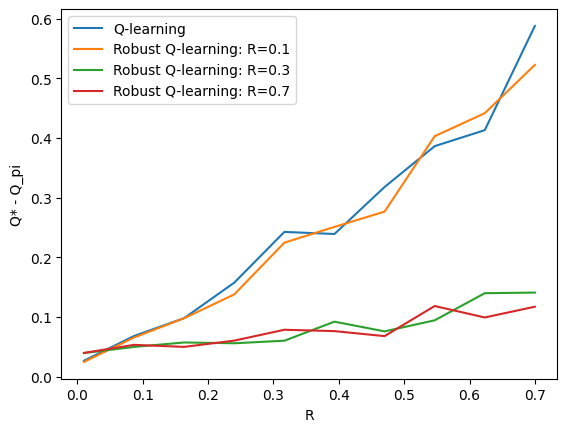

In [114]:
import matplotlib.pyplot as plt

num_perturb = 100
key = jax.random.PRNGKey(3)
Rs = jnp.linspace(0.01, 0.7, 10)

# Q学習の評価をします
key, Q = Q_learning(perturbed_mdp, 1000000, key, lr=0.1, epsilon=0.3)
Q_learning_greedy_policy = compute_greedy_policy(Q)

Q_learning_results = []
for R in Rs:
    Q_error = []
    for n in range(num_perturb):
        key, perturbed_mdp = perturb_mdp(key, mdp, R)
        error = perturbed_mdp.optimal_Q - compute_policy_Q(perturbed_mdp, Q_learning_greedy_policy)
        Q_error.append(error.max())
    
    Q_learning_results.append(max(Q_error))
plt.plot(Rs, Q_learning_results, label="Q-learning")


# Robust Q学習の評価をします
Robust_Q_learning_policies = {}
policy_Rs = [0.1, 0.3, 0.7]
for R in policy_Rs:
    key, Q = Robust_Q_learning(perturbed_mdp, 1000000, key, R=R, lr=0.1, epsilon=0.3)
    Robust_Q_learning_policies[R] = compute_greedy_policy(Q)


for policy_R in policy_Rs:
    results = []
    for R in Rs:
        Q_error = []
        for n in range(num_perturb):
            key, perturbed_mdp = perturb_mdp(key, mdp, R)
            policy = Robust_Q_learning_policies[policy_R]
            error = perturbed_mdp.optimal_Q - compute_policy_Q(perturbed_mdp, policy)
            Q_error.append(error.max())
        
        results.append(max(Q_error))
    plt.plot(Rs, results, label=f"Robust Q-learning: R={policy_R}")
    

plt.xlabel("R")
plt.ylabel("Q* - Q_pi")
plt.legend()

ちゃんとRobustな方策が得られてそうですね。良かったよかった。